<a href="https://colab.research.google.com/github/yeisonluna/RegistroMultimodal/blob/main/Registro_Multimodal_NORMALIZED_MUTUAL_INFO_Multiescala_v_final_Yeison_Luna_TG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**REGISTRO MULTIMODAL DE IMÁGENES CON INFORMACIÓN MUTUA - BÚSQUEDA MULTIESCALA**



---




Importación de Bibliotecas

In [13]:
import numpy as np  #paquete de arreglos
import matplotlib as pyplot 
import matplotlib.pyplot as plt  # paquete de gráficos
import cv2 
from scipy import ndimage
from google.colab.patches import cv2_imshow # para imprimir imágenes

Se importan las imágenes, guardadas en un drive de google.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importación de Imágenes

In [15]:
plt.style.use('ggplot')
imagen1 = cv2.imread("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/PodoscopioPreProcesadaFinalIzq.JPG")
imagen2 = cv2.imread("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/PresionPreProcesadaFinalIzq.JPG")
#imagen1 = cv2.imread("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/Podoscopio_preprocesada_total.JPG")
#imagen2 = cv2.imread("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/Presion_estimacion_escala_shift.TIFF")

# Funciones del algoritmo

Función de Información mutua

In [16]:
######### Información mutua

def mutual_information(hgram):
   # Convertir los recuentos de los rangos en valores de probabilidad
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal para x sobre y
    py = np.sum(pxy, axis=0) # marginal para y sobre x
    px_py = px[:, None] * py[None, :] # multiplicar probabilidades 
    # Ahora podemos hacer el cálculo usando las matrices 2D pxy, px_py
    nzs = pxy > 0 # Solo valores no nulos en la suma
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

######## Info mutua normalizada
EPS = np.finfo(float).eps

def mutual_information_2d(x, y, sigma=1, normalized=True):
  """
  Computes (normalized) mutual information between two 1D variate from a
  joint histogram.
  Parameters
  ----------
  x : 1D array
      first variable
  y : 1D array
      second variable
  sigma: float
      sigma for Gaussian smoothing of the joint histogram
  Returns
  -------
  nmi: float
      the computed similariy measure
  """
  bins = (256, 256)



  jh = np.histogram2d(x, y, bins=bins)[0]

  # smooth the jh with a gaussian filter of given sigma
  ndimage.gaussian_filter(jh, sigma=sigma, mode='constant',
                                output=jh)

  # compute marginal histograms
  jh = jh + EPS
  sh = np.sum(jh)
  jh = jh / sh
  s1 = np.sum(jh, axis=0).reshape((-1, jh.shape[0]))
  s2 = np.sum(jh, axis=1).reshape((jh.shape[1], -1))

  # Normalised Mutual Information of:
  # Studholme,  jhill & jhawkes (1998).
  # "A normalized entropy measure of 3-D medical image alignment".
  # in Proc. Medical Imaging 1998, vol. 3338, San Diego, CA, pp. 132-143.
  if normalized:
      mi = ((np.sum(s1 * np.log(s1)) + np.sum(s2 * np.log(s2)))
              / np.sum(jh * np.log(jh))) - 1
  else:
      mi = ( np.sum(jh * np.log(jh)) - np.sum(s1 * np.log(s1))
              - np.sum(s2 * np.log(s2)))

  return mi

Funcion multiescala

In [17]:
def scale_img_1(im1, im2):
    
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    escala_max = 1

# ----------------------------------- Ciclo 1 -------------------------------- #
    for i in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m1 = escala_max/n_int
        b1 = 0.2
        f = float(m1*i+b1)
    
        escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,f)
        img2 = cv2.warpAffine(img2, escala_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_1.append(mi)
        print("información mutua en escala: ",f," ", mi)


       
    
    mutual_info_1 = np.asarray(mutual_info_1)        
    scale = np.where(mutual_info_1==max(mutual_info_1))
    escala = scale[0]
    
    print("La primera escala es: ",m1*escala+b1)

    funcion_final = float(m1*escala)
    

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,funcion_final)
    dst = cv2.warpAffine(img2, escala_matrix, (cols,rows))

    return dst, escala 

def scale_img_2(im1,im2,escala):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    escala_max = 1

    for j in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        

        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m2 = 2*escala_max/(n_int**2)
        b2 = 0.2 + escala_max*(escala-1)/n_int 
        g = float(m2*j+b2)
    
        escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,g)
        img2 = cv2.warpAffine(img2, escala_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_2.append(mi)
        print("información mutua en escala: ",g," ", mi)


       
    
    mutual_info_2 = np.asarray(mutual_info_2)        
    scale_2 = np.where(mutual_info_2==max(mutual_info_2))
    escala_2 = scale_2[0]
    
    print("La segunda escala es: ",m2*escala_2+b2)

    funcion_final = float(m2*escala_2+b2)    
 

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,funcion_final)
    dst = cv2.warpAffine(img2, escala_matrix, (cols,rows))

    return dst, escala_2
    

def scale_img_3(im1,im2,escala,escala_2):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    escala_max = 1


    for k in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m3 = 4*escala_max/(n_int**3)
        b3 = 0.2 + escala_max*(escala-1)/n_int + 2*escala_max*(escala_2-1)/(n_int**2)
        h = float(m3*k+b3)
    
        escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,h)
        img2 = cv2.warpAffine(img2, escala_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_3.append(mi)
        print("información mutua en escala: ",h," ", mi)


       
    
    mutual_info_3 = np.asarray(mutual_info_3)        
    scale_3 = np.where(mutual_info_3==max(mutual_info_3))
    escala_3 = scale_3[0]
    
    print("La tercera escala es: ",m3*escala_3+b3)
    
    m_final = 4*escala_max/(n_int**3)
    b_final = 0.2 + escala_max*(escala-1)/n_int + 2*escala_max*(escala_2-1)/(n_int**2)
    funcion_final = float(m_final*escala_3+b_final)
    
 

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),0,funcion_final)
    dst = cv2.warpAffine(img2, escala_matrix, (cols,rows))
            
    
    return dst, funcion_final



Funciones de traslacion

In [18]:
def shift_img_x_1(im1, im2):
    
    
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    n_bins = 20
    
    
 #--------------------------------- Ciclo 1 ------------------------------------------
    
    for i in range (n_int+1): #Ciclo 1 (Se divide la imagen en intervalos de tamaño n_int)
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m1 = 2*cols/n_int   
        b1 = 0-cols
        f = (m1*i + b1)
            
        shift_matrix_x_axis = np.float32([[1,0,f],[0,1,0]])
        img2 = cv2.warpAffine(img2, shift_matrix_x_axis, (cols,rows))
            
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_1.append(mi)
        print("información mutua en traslacion x: ",f," ", mi)


       
    
    mutual_info_1 = np.asarray(mutual_info_1)        
    shift_x = np.where(mutual_info_1==max(mutual_info_1))
    traslacion_x = shift_x[0]
    
    print("La primera traslacion es: ",m1*traslacion_x+b1)

    funcion_final = (m1*traslacion_x+b1) 
 

    shift_matrix_x_axis = np.float32([[1,0,funcion_final],[0,1,0]])
    dst = cv2.warpAffine(im2, shift_matrix_x_axis, (cols,rows))
            
    
    return dst, traslacion_x

def shift_img_x_2(im1, im2, traslacion_x):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_2=[]
    n_bins = 20

    for j in range (n_int+1): 
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2 
        #img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m2 = 2*(2*cols)/(n_int**2)
        b2 = (2*cols*(traslacion_x-1))/n_int - (cols)
        g = (m2*j+b2)
                
        shift_matrix_x_axis = np.float32([[1,0,g],[0,1,0]])
        img2 = cv2.warpAffine(img2, shift_matrix_x_axis, (cols,rows))
            
        # Histograma en 2d
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_2.append(mi)
        print("información mutua en traslacion x: ",g," ", mi)


       
    
    mutual_info_2 = np.asarray(mutual_info_2)        
    shift_x_2 = np.where(mutual_info_2==max(mutual_info_2))
    traslacion_x_2 = shift_x_2[0]
    
    print("La segunda traslacion es: ",m2*traslacion_x_2+b2)

    funcion_final = (m2*traslacion_x_2+b2)
    
 

    shift_matrix_x_axis = np.float32([[1,0,funcion_final],[0,1,0]])
    dst = cv2.warpAffine(im2, shift_matrix_x_axis, (cols,rows))
            
    
    return dst, traslacion_x_2

def shift_img_x_3(im1,im2,traslacion_x,traslacion_x_2):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20

    for k in range (n_int+1): #Ciclo 1 (Se divide la imagen en intervalos de tamaño n_int)
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2
        #img2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m3 = 2*(4*cols)/(n_int**3)
        b3 = 2*(2*cols)*(traslacion_x_2-1)/(n_int**2) + (2*cols*(traslacion_x-1))/n_int - (cols)
        h = (m3*k+b3)
                
        shift_matrix_x_axis = np.float32([[1,0,h],[0,1,0]])
        img2 = cv2.warpAffine(img2, shift_matrix_x_axis, (cols,rows))
            
        # Histograma en 2d
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_3.append(mi)
        print("información mutua en traslacion x: ",h," ", mi)


       
    
    mutual_info_3 = np.asarray(mutual_info_3)        
    shift_x_3 = np.where(mutual_info_3==max(mutual_info_3))
    traslacion_x_3 = shift_x_3[0]
    
    print("La tercera traslacion es: ",m3*traslacion_x_3+b3)
    

    m_final = 2*(4*cols)/(n_int**3)
    b_final = 2*(2*cols)*(traslacion_x_2-1)/(n_int**2) + (2*cols*(traslacion_x-1))/n_int - (cols)
    funcion_final = (m_final*traslacion_x_3+b_final)
    
 

    shift_matrix_x_axis = np.float32([[1,0,funcion_final],[0,1,0]])
    dst = cv2.warpAffine(im2, shift_matrix_x_axis, (cols,rows))
            
    
    return dst, funcion_final




Función de traslación en y

In [19]:
def shift_img_y_1(im1, im2):   
   
    
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    n_bins = 20
    
 #--------------------------------- Ciclo 1 ------------------------------------------
    
    for i in range (n_int+1): #Ciclo 1 (Se divide la imagen en intervalos de tamaño n_int)
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m1 = 2*rows/n_int   
        b1 = 0-rows
        f = (m1*i + b1)
            
        shift_matrix_y_axis = np.float32([[1,0,0],[0,1,f]])
        img2 = cv2.warpAffine(img2, shift_matrix_y_axis, (cols,rows))
            
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_1.append(mi)
        print("información mutua en traslacion y: ",f," ", mi)


       
    
    mutual_info_1 = np.asarray(mutual_info_1)        
    shift_y = np.where(mutual_info_1==max(mutual_info_1))
    traslacion_y = shift_y[0]
    
    print("La primera traslacion es: ",m1*traslacion_y+b1)

    funcion_final = (m1*traslacion_y + b1)    
 

    shift_matrix_y_axis = np.float32([[1,0,0],[0,1,funcion_final]])
    dst = cv2.warpAffine(im2, shift_matrix_y_axis, (cols,rows))
    
    return dst, traslacion_y


def shift_img_y_2(im1,im2,traslacion_y):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_2=[]
    n_bins = 20

    for j in range (n_int+1): #Ciclo 1 (Se divide la imagen en intervalos de tamaño n_int)
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m2 = 2*(2*rows)/(n_int**2)
        b2 = (2*rows*(traslacion_y-1))/n_int - (rows)
        g = (m2*j+b2)
                
        shift_matrix_y_axis = np.float32([[1,0,0],[0,1,g]])
        img2 = cv2.warpAffine(img2, shift_matrix_y_axis, (cols,rows))
            
        # Histograma en 2d
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_2.append(mi)
        print("información mutua en traslacion y: ",g," ", mi)


       
    
    mutual_info_2 = np.asarray(mutual_info_2)        
    shift_y_2 = np.where(mutual_info_2==max(mutual_info_2))
    traslacion_y_2 = shift_y_2[0]
    
    print("La segunda traslacion es: ",m2*traslacion_y_2+b2)

    funcion_final = (m2*traslacion_y_2+b2)     

    shift_matrix_y_axis = np.float32([[1,0,0],[0,1,funcion_final]])
    dst = cv2.warpAffine(im2, shift_matrix_y_axis, (cols,rows))
    
    return dst, traslacion_y_2

def shift_img_y_3(im1,im2,traslacion_y,traslacion_y_2):

    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_3=[]
    n_bins = 20

    for k in range (n_int+1): #Ciclo 1 (Se divide la imagen en intervalos de tamaño n_int)
        
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)  #Imagenes a blanco y negro
        img2 = im2
        
        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m3 = 2*(4*rows)/(n_int**3)
        b3 = 2*(2*rows)*(traslacion_y_2-1)/(n_int**2) + (2*rows*(traslacion_y-1))/n_int - (rows)
        h = (m3*k+b3)
                
        shift_matrix_y_axis = np.float32([[1,0,0],[0,1,h]])
        img2 = cv2.warpAffine(img2, shift_matrix_y_axis, (cols,rows))
            
        # Histograma en 2d
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_3.append(mi)
        print("información mutua en traslacion y: ",h," ", mi)


       
    
    mutual_info_3 = np.asarray(mutual_info_3)        
    shift_y_3 = np.where(mutual_info_3==max(mutual_info_3))
    traslacion_y_3 = shift_y_3[0]
    
    print("La tercera traslacion es: ",m3*traslacion_y_3+b3)
    

    m_final = 2*(4*rows)/(n_int**3)
    b_final = 2*(2*rows)*(traslacion_y_2)/(n_int**2) + (2*rows*(traslacion_y-1))/n_int - (rows)
    funcion_final = (m_final*traslacion_y_3+b_final)
    
 

    shift_matrix_y_axis = np.float32([[1,0,0],[0,1,funcion_final]])
    dst = cv2.warpAffine(im2, shift_matrix_y_axis, (cols,rows))
            
    
    return dst, funcion_final


Función de rotación

In [20]:
def rotation_matrix_1(im1, im2):
        
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    angulo_max = 3

# ----------------------------------- Ciclo 1 ------------------------------------ #
    for i in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = im2

        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m1 = 2*angulo_max/n_int
        b1 = 0-angulo_max
        f = float(m1*i+b1)
    
        angulo_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),f,1)
        img2 = cv2.warpAffine(img2, angulo_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_1.append(mi)
        print("información mutua en rotacion: ",f," ", mi)


       
    
    mutual_info_1 = np.asarray(mutual_info_1)        
    angle = np.where(mutual_info_1==max(mutual_info_1))
    angulo = angle[0]
    
    print("La primera rotación es: ",m1*angulo+b1)

    funcion_final = float(m1*angulo+b1)
    
 

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),funcion_final,1)
    dst = cv2.warpAffine(im2, escala_matrix, (cols,rows))
            
    
    return dst, angulo

def rotation_matrix_2(im1, im2, angulo):
        
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    angulo_max = 3

    for j in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = im2

        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m2 = 2*2*angulo_max/(n_int**2)
        b2 = 2*angulo_max*(angulo-1)/n_int - angulo_max
        g = float(m2*j+b2)
    
        angulo_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),g,1)
        img2 = cv2.warpAffine(img2, angulo_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_2.append(mi)
        print("información mutua en rotación: ",g," ", mi)


       
    
    mutual_info_2 = np.asarray(mutual_info_2)        
    angle_2 = np.where(mutual_info_2==max(mutual_info_2))
    angulo_2 = angle_2[0]
    
    print("La segunda rotación es: ",m2*angulo_2+b2)

    funcion_final = float(m2*angulo_2+b2)
     

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),funcion_final,1)
    dst = cv2.warpAffine(im2, escala_matrix, (cols,rows))
            
    
    return dst, angulo_2

def rotation_matrix_3(im1, im2, angulo, angulo_2):
        
    n_int = 20   #Numero de Intervalos de busqueda multiescala
    mutual_info_1=[] #Arreglos de valores de info mutua
    mutual_info_2=[]
    mutual_info_3=[]
    n_bins = 20
    angulo_max = 3

    for k in range (n_int+1):
        
        img1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) 
        img2 = im2

        #Obtener el tamaño de la imagen
        rows, cols = img1.shape[:2]
        
        m3 = 2*4*angulo_max/(n_int**3)
        b3 = 2*angulo_max*(angulo-1)/n_int + 2*2*angulo_max*(angulo_2-1)/(n_int**2) - angulo_max
        h = float(m3*k+b3)
    
        angulo_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),h,1)
        img2 = cv2.warpAffine(img2, angulo_matrix, (cols,rows))
        
        #hist_2d, x_edges, y_edges = np.histogram2d(
        #img1.ravel(),
        #img2.ravel(),
        #bins=n_bins)
            
        # Calcular la información mutua entre las dos imágenes 
        mi = mutual_information_2d(img1.ravel(),img2.ravel())

            
        mutual_info_3.append(mi)
        print("información mutua en rotación: ",h," ", mi)


       
    
    mutual_info_3 = np.asarray(mutual_info_3)        
    angle_3 = np.where(mutual_info_3==max(mutual_info_3))
    angulo_3 = angle_3[0]
    
    print("La tercera rotación es: ",m3*angulo_3+b3)
    
    m_final = 2*4*angulo_max/(n_int**3)
    b_final = angulo_max*(angulo-1)/n_int + 2*angulo_max*(angulo_2-1)/(n_int**2)
    funcion_final = float(m_final*angulo_3+b_final)
    
 

    escala_matrix = cv2.getRotationMatrix2D((cols/2,rows/2),funcion_final,1)
    dst = cv2.warpAffine(im2, escala_matrix, (cols,rows))
            
    
    return dst, funcion_final


# Resultados






Primera variación de parámetros en orden: escala, traslación x, traslación y, rotación: 

información mutua en escala:  0.2   0.003865760595444634
información mutua en escala:  0.25   0.005698974805298906
información mutua en escala:  0.30000000000000004   0.007892161946065457
información mutua en escala:  0.35000000000000003   0.010225484437336618
información mutua en escala:  0.4   0.01262924575389679
información mutua en escala:  0.45   0.015468169459459613
información mutua en escala:  0.5   0.019029962283201973
información mutua en escala:  0.55   0.022903590593575718
información mutua en escala:  0.6000000000000001   0.027866069077046474
información mutua en escala:  0.65   0.03346422103350788
información mutua en escala:  0.7   0.039345707998059476
información mutua en escala:  0.75   0.04584682291628672
información mutua en escala:  0.8   0.051680694214629286
información mutua en escala:  0.8500000000000001   0.05608528092214171
información mutua en escala:  0.9000000000000001 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(<matplotlib.axes._subplots.AxesSubplot at 0x7fc552a06550>,
 Text(0.5, 1.0, 'Registro Completo'))

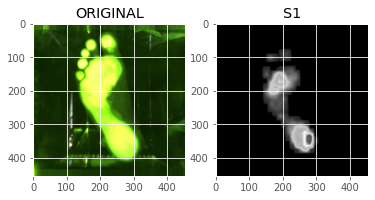

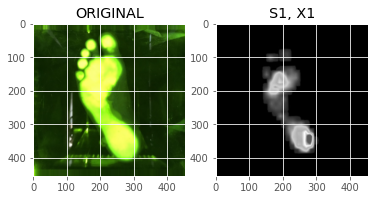

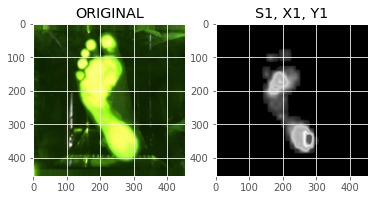

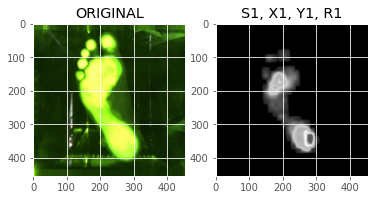

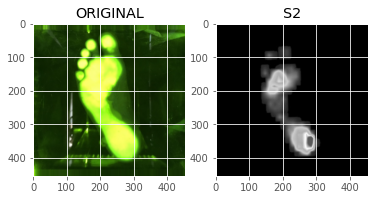

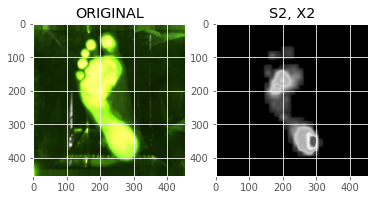

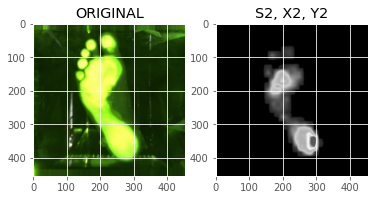

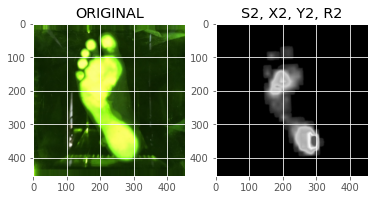

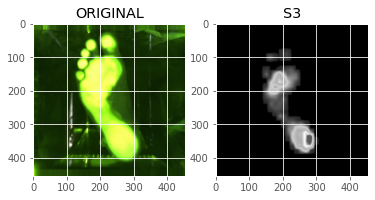

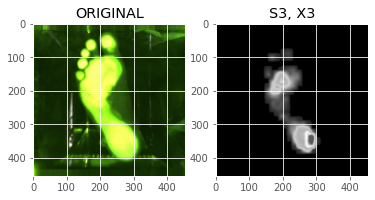

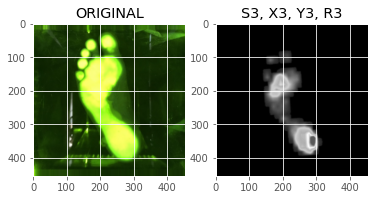

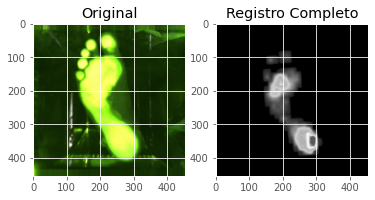

In [21]:
#----------------------------------------------------------------------------------------#
#Primera variación de parámetros en orden: escala, traslación x, traslación y, rotación:

print("Primera variación de parámetros en orden: escala, traslación x, traslación y, rotación: \n")

imagen2_s1, s1 = scale_img_1(imagen1, imagen2)

plt.figure(0)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_s1,'gray'),plt.title('S1')

imagen2_sx1, x1 = shift_img_x_1(imagen1, imagen2_s1)

plt.figure(1)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sx1,'gray'),plt.title('S1, X1')

imagen2_sxy1, y1 = shift_img_y_1(imagen1, imagen2_sx1)

plt.figure(2)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxy1,'gray'),plt.title('S1, X1, Y1')

imagen2_sxyr1, r1 = rotation_matrix_1(imagen1, imagen2_sxy1)

plt.figure(3)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxyr1,'gray'),plt.title('S1, X1, Y1, R1')

print("\n")

#----------------------------------------------------------------------------------------#
#Segunda variación de parámetros en orden: escala, traslación x, traslación y, rotación:
print("Segunda variación de parámetros en orden: escala, traslación x, traslación y, rotación: \n")

imagen2_s2, s2 = scale_img_2(imagen1, imagen2, s1)

plt.figure(4)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_s2,'gray'),plt.title('S2')

imagen2_sx2, x2 = shift_img_x_2(imagen1, imagen2_s2, x1)

plt.figure(5)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sx2,'gray'),plt.title('S2, X2')

imagen2_sxy2, y2 = shift_img_y_2(imagen1, imagen2_sx2, y1)

plt.figure(6)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxy2,'gray'),plt.title('S2, X2, Y2')


imagen2_sxyr2, r2 = rotation_matrix_2(imagen1, imagen2_sxy2, r1)

plt.figure(7)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxyr2,'gray'),plt.title('S2, X2, Y2, R2')

print("\n")

#----------------------------------------------------------------------------------------#
#Tercera variación de parámetros en orden: escala, traslación x, traslación y, rotación:

print("Tercera variación de parámetros en orden: escala, traslación x, traslación y, rotación: \n")

imagen2_s3, s3 = scale_img_3(imagen1, imagen2, s1, s2)

plt.figure(8)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_s3,'gray'),plt.title('S3')

imagen2_sx3, x3 = shift_img_x_3(imagen1, imagen2_s3, x1, x2)

plt.figure(9)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sx3,'gray'),plt.title('S3, X3')

imagen2_sxy3, y3 = shift_img_y_3(imagen1, imagen2_sx3, y1, y2)

plt.figure(10)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxy3,'gray'),plt.title('S3, X3, Y3')


imagen2_sxyr3, r3 = rotation_matrix_3(imagen1, imagen2_sxy3, r1, r2)

plt.figure(10)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('ORIGINAL')
plt.subplot(122),plt.imshow(imagen2_sxyr3,'gray'),plt.title('S3, X3, Y3, R3')



#----------------------------------------------------------------------------------------#
# Mostrando el resultado final #


plt.figure(11)
plt.subplot(121),plt.imshow(imagen1,'gray'),plt.title('Original')
plt.subplot(122),plt.imshow(imagen2_sxyr3,'gray'),plt.title('Registro Completo')


Resultados en BGR

(455, 455, 3)


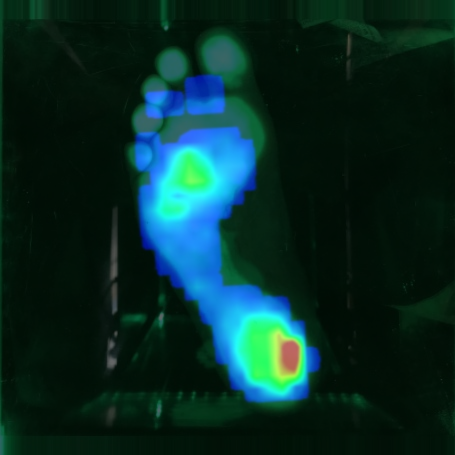

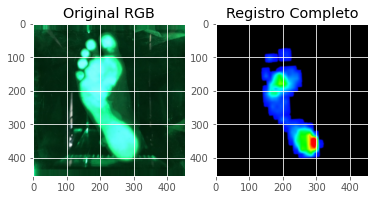

In [22]:

# Mostrando el resultado final en BGR #

presion_BGR= cv2.imread("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/PresionPreProcesadaFinalIzq.JPG")
print(presion_BGR.shape)
(presion_B,presion_G,presion_R) = cv2.split(presion_BGR)

rows, cols, channels = presion_BGR.shape

M_escala = cv2.getRotationMatrix2D((cols/2,rows/2),0,s3)
M_traslacion_x = np.float32([[1,0,x3],[0,1,0]])
M_traslacion_y = np.float32([[1,0,0],[0,1,y3]])
M_rotacion = cv2.getRotationMatrix2D((cols/2,rows/2),r3,1)

presion_B = cv2.warpAffine(presion_B, M_escala, (cols,rows))
presion_B = cv2.warpAffine(presion_B, M_traslacion_x, (cols,rows))
presion_B = cv2.warpAffine(presion_B, M_traslacion_y, (cols,rows))
presion_B = cv2.warpAffine(presion_B, M_rotacion, (cols,rows))

presion_G = cv2.warpAffine(presion_G, M_escala, (cols,rows))
presion_G = cv2.warpAffine(presion_G, M_traslacion_x, (cols,rows))
presion_G = cv2.warpAffine(presion_G, M_traslacion_y, (cols,rows))
presion_G = cv2.warpAffine(presion_G, M_rotacion, (cols,rows))

presion_R = cv2.warpAffine(presion_R, M_escala, (cols,rows))
presion_R = cv2.warpAffine(presion_R, M_traslacion_x, (cols,rows))
presion_R = cv2.warpAffine(presion_R, M_traslacion_y, (cols,rows))
presion_R = cv2.warpAffine(presion_R, M_rotacion, (cols,rows))

presion_BGR_registro = cv2.merge([presion_B,presion_G,presion_R])

imagen1_RGB = cv2.cvtColor(imagen1, cv2.COLOR_BGR2RGB)
presion_RGB_registro = cv2.cvtColor(presion_BGR_registro, cv2.COLOR_BGR2RGB)

plt.figure(12)
plt.subplot(121), plt.imshow(imagen1_RGB), plt.title('Original RGB')
plt.subplot(122),plt.imshow(presion_RGB_registro),plt.title('Registro Completo')

#Mostrar la imagen fusionada
I_fusionada = cv2.addWeighted(imagen1,0.4,presion_BGR_registro,0.6,0)
cv2_imshow(I_fusionada)



Métricas de comparación

La información mutua es:  0.326549236235382
La información mutua es:  0.06510427898828941
La sumatoria de diferencias al cuadrado es:  [[8.537347e+08]]


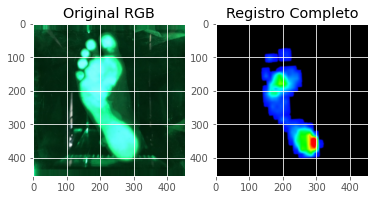

In [23]:
#Midiendo la información mutua final del registro
imagen1_RGB_gris = cv2.cvtColor(imagen1_RGB, cv2.COLOR_RGB2GRAY)
presion_RGB_registro_gris = cv2.cvtColor(presion_RGB_registro, cv2.COLOR_RGB2GRAY)

hist_2d, x_edges, y_edges = np.histogram2d(imagen1_RGB_gris.ravel(),presion_RGB_registro_gris.ravel(),bins=64)
    
# Calcular la información mutua entre las dos imágenes 
info_mutua_final = mutual_information(hist_2d)
info_mutua_otra = mutual_information_2d(imagen1_RGB_gris.ravel(),presion_RGB_registro_gris.ravel())

#Midiendo la suma de diferencias al cuadrado
sqdiff = cv2.matchTemplate(imagen1_RGB_gris, presion_RGB_registro_gris, cv2.TM_SQDIFF)


plt.figure(13)
plt.subplot(121), plt.imshow(imagen1_RGB), plt.title('Original RGB')
plt.subplot(122),plt.imshow(presion_RGB_registro),plt.title('Registro Completo')

print("La información mutua es: ",info_mutua_final)
print("La información mutua es: ",info_mutua_otra)
print("La sumatoria de diferencias al cuadrado es: ",sqdiff)



Salida de imagen

In [24]:
Salida_registro = cv2.imwrite("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/Registro_Completo_MUTUAL_INFO.JPG",imagen2_sxyr3)
Salida_registro_BGR = cv2.imwrite("/content/drive/MyDrive/Trabajo de grado - Yeison Luna/Imagenes - Pruebas/Prueba 01-06-2021/Registro_Completo_BGR_MUTUAL_INFO.JPG",presion_BGR_registro)